In [265]:
import pandas as pd
import numpy as np

from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

#basic text manipulation libraries
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer

import string

import gensim
#plotting tools
import pyLDAvis
#import pyLDAvis.gensim #dont skip this

import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\adity\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [266]:
neg_reviews = pd.read_csv('data/neg_reviews.csv')
neg_reviews.head()


,reviews,tokens,sentiment
0,BA cancelled my flight home to Heathrow on Dec...,"['cancelled', 'home', 'heathrow', 'dec', '19th...",0
1,"BA cancelled my flight home, the last flight o...","['cancelled', 'home', 'last', 'day', 'heathrow...",0
2,"Turned up 3.5 hours in advance, Terminal 5 at ...","['turned', '3.5', 'hours', 'advance', 'termina...",0
3,Boarding – at gate at LGW they called Group 1 ...,"['boarding', '–', 'gate', 'lgw', 'called', 'gr...",0
4,Missing baggage customer service was the worst...,"['missing', 'baggage', 'customer', 'service', ...",0


In [267]:
X_train,X_hold = train_test_split(neg_reviews,test_size=0.7,random_state=111)


In [268]:
stemmer=SnowballStemmer(language='english')


In [269]:
def tokenize(txt):
    tokens=[word for word in nltk.word_tokenize(txt) if len(word)>3]
    return tokens

In [270]:
tokenize(txt="Here’s the real reason to turn on aeroplane mode when you fly Is it true our phones are dangerous for aircraft navigation?")

['Here',
 'real',
 'reason',
 'turn',
 'aeroplane',
 'mode',
 'when',
 'true',
 'phones',
 'dangerous',
 'aircraft',
 'navigation']

LDA only needs count of the word and do not rquire normalized word

In [271]:
stpwrd = nltk.corpus.stopwords.words('english')
stpwrd.extend(string.punctuation)
stpwrd.extend(['like','have','any','could','sister','would','said','asked','london'])

In [272]:
vectorizer =TfidfVectorizer(tokenizer=tokenize,
                            stop_words=stpwrd,
                            max_df=0.75,
                            min_df=50,
                            use_idf=False,
                            norm=None)
tf_vectors = vectorizer.fit_transform(X_train.reviews)





c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\sklearn\feature_extraction\text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['might', 'must', 'need'] not in stop_words.
  warnings.warn(


In [273]:
vectorizer1 = CountVectorizer(stop_words=stpwrd,
                            max_df=0.75,
                            min_df=50)
count_vectors = vectorizer1.fit_transform(X_train.reviews)

In [274]:
tf_vectors.A

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 2., ..., 0., 1., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 2., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.]])

In [275]:
lda = decomposition.LatentDirichletAllocation(
        n_components=6, # no of topics
        max_iter=20, 
        learning_method='online', #min batch of the dataset
        learning_offset=50, #
        n_jobs=-1,
        random_state=111
)

W1=lda.fit_transform(tf_vectors)
H1 = lda.components_

In [276]:
W1

array([[0.02093612, 0.46900244, 0.02099234, 0.02086524, 0.02101627,
        0.44718759],
       [0.63128062, 0.00392253, 0.00389867, 0.35307828, 0.00391119,
        0.00390869],
       [0.01526048, 0.01544679, 0.01528655, 0.01521209, 0.92357198,
        0.01522211],
       ...,
       [0.00698128, 0.00701031, 0.29971995, 0.00699906, 0.00699524,
        0.67229416],
       [0.00700127, 0.00702851, 0.50060399, 0.00698999, 0.47131068,
        0.00706556],
       [0.13516963, 0.00600074, 0.00601232, 0.15419809, 0.69263476,
        0.00598446]])

In [277]:
num_words = 15

vocab = np.array(vectorizer.get_feature_names_out())
top_words = lambda t:[vocab[i] for i in np.argsort(t)[:-num_words-1:-1]]
topic_words = ([top_words(t) for t in H1])
topics = [' '.join(t) for t in topic_words]

In [278]:
topics

['economy premium service seat meal food cabin crew water served better drink plane seats offered',
 'staff food first service airline poor cabin heathrow seats class even choice experience meal crew',
 'class business airways british seat seats passengers time heathrow staff service flew food boarding people',
 'british airways airlines return flights service airline customer good gatwick people nothing booked long drink',
 'crew cabin time food lounge good club seat aircraft service return boarding passengers late minutes',
 'hours told customer service luggage heathrow hour plane airport booked another back days time delayed']

In [279]:
colnames = ["Topic"+str(i) for i in range(lda.n_components)]
docnames = ["Doc" + str(i) for i in range(len(X_train.reviews))]

df_doc_topic  =pd.DataFrame(np.round(W1,2),columns=colnames,index=docnames)
significant_topic = np.argmax(df_doc_topic.values,axis=1)
df_doc_topic['dominant_topic'] = significant_topic

In [280]:
df_doc_topic

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,dominant_topic
Doc0,0.02,0.47,0.02,0.02,0.02,0.45,1
Doc1,0.63,0.00,0.00,0.35,0.00,0.00,0
Doc2,0.02,0.02,0.02,0.02,0.92,0.02,4
Doc3,0.00,0.58,0.00,0.00,0.41,0.00,1
Doc4,0.06,0.46,0.00,0.00,0.47,0.00,4
...,...,...,...,...,...,...,...
Doc441,0.01,0.01,0.01,0.23,0.01,0.73,5
Doc442,0.01,0.01,0.01,0.01,0.70,0.26,4
Doc443,0.01,0.01,0.30,0.01,0.01,0.67,5
Doc444,0.01,0.01,0.50,0.01,0.47,0.01,2


In [281]:
X_train.head()

,reviews,tokens,sentiment
171,I was refused an early check in and was told t...,"['refused', 'early', 'check', 'told', 'come', ...",0
917,"Unimpressed! Service very indifferent, impress...","['unimpressed', 'service', 'indifferent', 'imp...",0
99,Very low standards for Club Europe: there was ...,"['low', 'standards', 'club', 'europe', 'cabin'...",0
1293,Montreal to London and return to Toronto. O/W ...,"['montreal', 'london', 'return', 'toronto', 'o...",0
1334,My wife and I have been flying British Airways...,"['wife', 'flying', 'british', 'airways', 'shor...",0


In [282]:
X_train.head().tail(1).reviews.values

array(['My wife and I have been flying British Airways short haul in Club Europe for several years and until recently have been more than satisfied with the service provided. Noticeably, this year that service has become far more erratic culminating in an extremely poor performance and unpleasant experience on this recent flight to Malta ex Gatwick. Departure time was 0750 and we arrived at Premium Check-in at 0620 to find only one member of staff manning the desks serving First and Club. There were at least 10 parties waiting in the queue, some of whom defected to Economy desks which were heavily manned with faster moving queues. Only after more than 15 minutes did extra staff arrive and when we reached the desk the attitude of the Check-in lady left much to be desired - robotic, unsmiling and disinterested is probably a kind description. It would have been good to have been informed that the No 1 Lounge was available in the absence of the BA offering, but no mention of a lounge was m

In [283]:
topics[2]

'class business airways british seat seats passengers time heathrow staff service flew food boarding people'

Print the top words for each topic by looping through the components_ attribute of the LDA model and sorting the words by their weights in each topic.

In [284]:
# Print the top words for each topic
word_list=[]
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    topic_words = [vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-15:]]
    word_list=word_list+topic_words
    print(topic_words)
    

Topic 1:
['offered', 'seats', 'plane', 'drink', 'better', 'served', 'water', 'crew', 'cabin', 'food', 'meal', 'seat', 'service', 'premium', 'economy']
Topic 2:
['crew', 'meal', 'experience', 'choice', 'even', 'class', 'seats', 'heathrow', 'cabin', 'poor', 'airline', 'service', 'first', 'food', 'staff']
Topic 3:
['people', 'boarding', 'food', 'flew', 'service', 'staff', 'heathrow', 'time', 'passengers', 'seats', 'seat', 'british', 'airways', 'business', 'class']
Topic 4:
['drink', 'long', 'booked', 'nothing', 'people', 'gatwick', 'good', 'customer', 'airline', 'service', 'flights', 'return', 'airlines', 'airways', 'british']
Topic 5:
['minutes', 'late', 'passengers', 'boarding', 'return', 'service', 'aircraft', 'seat', 'club', 'good', 'lounge', 'food', 'time', 'cabin', 'crew']
Topic 6:
['delayed', 'time', 'days', 'back', 'another', 'booked', 'airport', 'plane', 'hour', 'heathrow', 'luggage', 'service', 'customer', 'told', 'hours']


In [285]:

word_list

['offered',
 'seats',
 'plane',
 'drink',
 'better',
 'served',
 'water',
 'crew',
 'cabin',
 'food',
 'meal',
 'seat',
 'service',
 'premium',
 'economy',
 'crew',
 'meal',
 'experience',
 'choice',
 'even',
 'class',
 'seats',
 'heathrow',
 'cabin',
 'poor',
 'airline',
 'service',
 'first',
 'food',
 'staff',
 'people',
 'boarding',
 'food',
 'flew',
 'service',
 'staff',
 'heathrow',
 'time',
 'passengers',
 'seats',
 'seat',
 'british',
 'airways',
 'business',
 'class',
 'drink',
 'long',
 'booked',
 'nothing',
 'people',
 'gatwick',
 'good',
 'customer',
 'airline',
 'service',
 'flights',
 'return',
 'airlines',
 'airways',
 'british',
 'minutes',
 'late',
 'passengers',
 'boarding',
 'return',
 'service',
 'aircraft',
 'seat',
 'club',
 'good',
 'lounge',
 'food',
 'time',
 'cabin',
 'crew',
 'delayed',
 'time',
 'days',
 'back',
 'another',
 'booked',
 'airport',
 'plane',
 'hour',
 'heathrow',
 'luggage',
 'service',
 'customer',
 'told',
 'hours']

In [286]:
Counter(word_list)

Counter({'offered': 1,
         'seats': 3,
         'plane': 2,
         'drink': 2,
         'better': 1,
         'served': 1,
         'water': 1,
         'crew': 3,
         'cabin': 3,
         'food': 4,
         'meal': 2,
         'seat': 3,
         'service': 6,
         'premium': 1,
         'economy': 1,
         'experience': 1,
         'choice': 1,
         'even': 1,
         'class': 2,
         'heathrow': 3,
         'poor': 1,
         'airline': 2,
         'first': 1,
         'staff': 2,
         'people': 2,
         'boarding': 2,
         'flew': 1,
         'time': 3,
         'passengers': 2,
         'british': 2,
         'airways': 2,
         'business': 1,
         'long': 1,
         'booked': 2,
         'nothing': 1,
         'gatwick': 1,
         'good': 2,
         'customer': 2,
         'flights': 1,
         'return': 2,
         'airlines': 1,
         'minutes': 1,
         'late': 1,
         'aircraft': 1,
         'club': 1,
         'l

In [287]:
df_topic_words = pd.DataFrame.from_dict(Counter(word_list), orient='index', columns=['frequency'])
df_topic_words.sort_values('frequency',ascending=False,inplace=True)
df_topic_words.head()

,frequency
service,6
food,4
time,3
crew,3
seats,3


c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


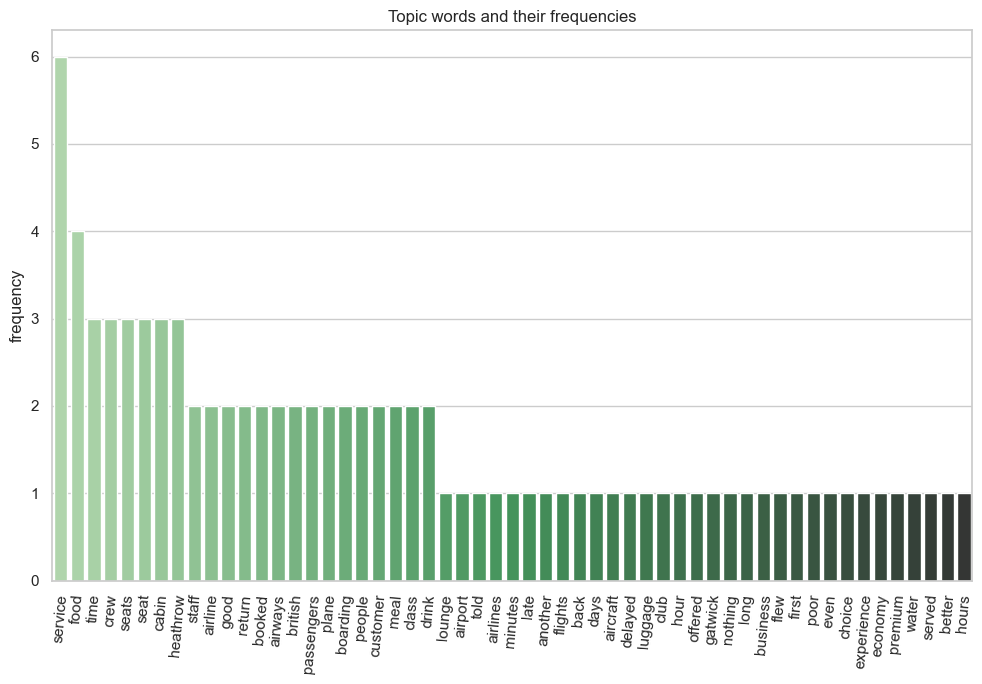

In [288]:
# create figure and axes
fig, ax = plt.subplots(figsize=(10,7), dpi=100)
sns.set(style="whitegrid", color_codes=True)
pal = sns.color_palette("Greens_d", len(df_topic_words))
sns.barplot(data=df_topic_words,x=df_topic_words.index,y='frequency',palette=pal)
plt.title('Topic words and their frequencies')
plt.xticks(rotation=85)
plt.tight_layout()

In [289]:
# Extract the text column
text = neg_reviews["reviews"]

# Convert the text to a matrix of term frequency-inverse document frequency (TF-IDF) features, including 2-grams
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(text)

# Build the Latent Dirichlet Allocation (LDA) model
lda = decomposition.LatentDirichletAllocation(n_components=10, random_state=42)

# Fit the model to the data
lda.fit(X)

# Print the top words for each topic
for i, topic in enumerate(lda.components_):
    print(f"Topic {i+1}:")
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-10:]])



Topic 1:


c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['two months', 'old with', 'min', 'unfriendly', 'change of', 'cello', 'my sister', 'sister', 'arrogant', 'counter']
Topic 2:
['we', 'flight', 'for', 'on', 'of', 'in', 'was', 'and', 'to', 'the']
Topic 3:
['never experienced', 'they took', 'phoned', 'outsourced', '2019', 'diego', 'san diego', 'fco', 'put us', 'rome']
Topic 4:
['to redeem', 'we only', 'off for', 'flight departed', '90', 'and told', 'transit', 'bumped', 'ba used', 'vegan']
Topic 5:
['bag of', 'gate the', 'more legroom', 'and when', 'my boarding', 'absolutely no', 'my seats', 'montreal', 'cabin luggage', 'allowance']
Topic 6:
['have any', 'to larnaca', 'jersey', 'ife was', 'oslo', 'offer any', 'counter', 'price for', 'san francisco', 'francisco']
Topic 7:
['bag for', 'seat assignments', 'transit', 'extortionate', 'san francisco', 'francisco', 'rome', 'airline has', 'kul', 'counter']
Topic 8:
['aus', 'snacks on', 'the upper', 'dhabi', 'abu dhabi', 'abu', 'been reduced', 'you cannot', 'buggy', 'reputation']
Topic 9:
['nobody'

In [290]:
import gensim
from gensim.models import Word2Vec

In [291]:
# Extract the text column
text = neg_reviews["reviews"]
reviews = [review.split() for review in text]

# Train a word2vec model on the reviews
model = Word2Vec(reviews, vector_size =100, window=5, min_count=1, workers=4)


# Get the word vectors for each review
review_vectors = []
for review in reviews:
    review_vectors.append(np.mean([model.wv[word] for word in review], axis=0))

# Use k-means clustering to cluster the review vectors into 10 clusters
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(review_vectors)

# Print the top words for each cluster
for i in range(10):
    cluster_reviews = [reviews[j] for j in range(len(reviews)) if kmeans.labels_[j] == i]
    words = [word for review in cluster_reviews for word in review]
    word_counts = {}
    for word in words:
        if word in word_counts:
            word_counts[word] += 1
        else:
            word_counts[word] = 1
    sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
    print(f"Topic {i+1}:")
    print([x[0] for x in sorted_word_counts[:10]])

c:\Users\adity\.conda\envs\env_pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Topic 1:
['the', 'to', 'and', 'a', 'was', 'I', 'of', 'in', 'for', 'on']
Topic 2:
['the', 'and', 'to', 'a', 'was', 'of', 'in', 'on', 'I', 'The']
Topic 3:
['to', 'the', 'I', 'and', 'a', 'was', 'of', 'for', 'my', 'in']
Topic 4:
['the', 'and', 'to', 'a', 'is', 'I', 'in', 'on', 'with', 'of']
Topic 5:
['the', 'was', 'and', 'to', 'a', 'of', 'The', 'in', 'on', 'were']
Topic 6:
['the', 'to', 'and', 'a', 'was', 'of', 'in', 'on', 'with', 'for']
Topic 7:
['to', 'I', 'the', 'a', 'and', 'for', 'was', 'have', 'my', 'that']
Topic 8:
['to', 'the', 'and', 'was', 'a', 'I', 'flight', 'for', 'in', 'on']
Topic 9:
['to', 'the', 'and', 'a', 'I', 'with', 'in', 'of', 'for', 'was']
Topic 10:
['to', 'the', 'I', 'and', 'was', 'a', 'in', 'that', 'for', 'flight']
